In [1]:
#Load data
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import arviz as az
#plt.style.use('science')
az.style.use(["science", "grid",  'tableau-colorblind10'])
%config InlineBackend.figure_format = 'retina'
import sys 
sys.path.append("../src/")
from utils.data import *
from net.model_org import FPQSeq2Q
from net.model_pil import model_pil
from net.utils import get_latest_checkpoint
import torch
from net.layers import Swish
import torch.nn as nn
activations = [Swish(), nn.ReLU(), nn.ELU(), nn.LeakyReLU(), nn.GELU()]
import seaborn as sns
from utils.visual_functions import *
from utils.metrics import *
nice_fonts = {
        # Use LaTeX to write all text
        "font.family": "serif",
        # Always save as 'tight'
        "savefig.bbox" : "tight",
        "savefig.pad_inches" : 0.05,
        "ytick.right" : True,
        "font.serif" : "Times New Roman",
        "mathtext.fontset" : "dejavuserif",
        "axes.labelsize": 15,
        "font.size": 15,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        # Set line widths
        "axes.linewidth" : 0.5,
        "grid.linewidth" : 0.5,
        "lines.linewidth" : 1.,
        # Remove legend frame
        "legend.frameon" : False
}
matplotlib.rcParams.update(nice_fonts)

In [2]:
#
# Params
hparams = {'N': 82,
                            'activation': 1,
                            'min_std':0.001, 
                            'dist_type':'normal',
                            'kmix':5,
                            'soft_max_type':'softmax',
                            'batch_size': 128,
                            'depth': 4,
                            'droput': 0.4,
                            'alpha': 0.5,
                            'entropy_loss': True,
                            'expansion_factor': 2,
                            'latent_size': 64,
                            'num_cosines': 64,
                            'num_head': 4,
                            'patch_size': 8,
                            'sampling': 1,
                            'kappa': 0.5583529712369528,
                            'margin': 1.0188749613200957e-06,
                            'scale': 'min_max',
                            'target_scale': 'min_max',
                            'clipping_value': 3.004622548809806,
                            'encoder_type': 'MLPEncoder',
                            'feature_start': 16,
                            'cnn_emb': False,
                            'huber_loss': True,
                            'calibration_loss': False,
                            'nrmse_loss': False,
                            'nll_loss': False,
                            'out_activation': None,
                            'droput': 0.38371718771118474,
                            'max_epochs': 200,
                            'period': '30T',
                            'rolling_window': 3,
                            'SAMPLES_PER_DAY': 48,
                            'time_varying_known_feature': ['Ghi'],
                            'time_varying_unknown_feature': ['Load-median-filter', 'Load-Ghi'],
                            'time_varying_known_categorical_feature': ['DAYOFWEEK', 'HOUR', 
                                                                       'WEEKDAY', 'WEEKEND', 
                                                                       'SATURDAY', 'SUNDAY'],
                            'categorical_dims': [52, 7, 356, 12, 32, 24, 2, 2, 2, 2],
                            'categorical_emb': False,
                            'targets': 'Load-target',
                            'window_size': 96,
                            'horizon': 48, 
                             'yearly_seasonality':"auto",
                             'weekly_seasonality':"auto",
                             'daily_seasonality':"auto",
                             'seasonality_mode':"additive",
                             'seasonality_reg':0,
                             'seasonality':True}

## Load checkpoints

In [3]:
#Load checkpoints
def prepare_model(hparams, encoder_type, checkpoint_path, n_channels=15):
    
    
    network = FPQSeq2Q(n_channels = n_channels,
                                                latent_size = hparams['latent_size'], 
                                                out_size = hparams['horizon'], 
                                                context_size = hparams['window_size'], 
                                                dropout = hparams['droput'],
                                                N = hparams['N'],
                                                huber_loss = hparams['huber_loss'],
                                                calibration_loss = hparams['calibration_loss'],
                                                entropy_loss = hparams['entropy_loss'],
                                                nrmse_loss = hparams['nrmse_loss'],
                                                out_activation=hparams["out_activation"],
                                                nll_loss = hparams['nll_loss'],
                                                patch_size= hparams['patch_size'], 
                                                expansion_factor =  hparams['expansion_factor'],        
                                                depth = hparams['depth'],
                                                num_head=hparams['num_head'],
                                                encoder_type=hparams['encoder_type'],
                                                num_cosines=hparams['num_cosines'],
                                                activation=activations[hparams['activation']])
                
            
                                        
                
    model   = model_pil(network, hparams)
    
    return model


def get_predictions(net, features, experiment):
    with torch.no_grad():
        z, h = net(features)
        taus, tau_hats, entropies, attn_output = net.get_quantile_proposals(features, z, h)
        quantile_hats = net.get_quantile_values(tau_hats,  h,z, attn_output)
        pred = (quantile_hats*(taus[:, 1:, :] - taus[:, :-1,:])).sum(dim=1)
            
            
    pred = experiment.target_transformer.inverse_transform(pred.numpy())[0]
    q_pred = quantile_hats.numpy()
    N, M, T = q_pred.shape
    q_pred = q_pred.reshape(N*M, T)
    q_pred = experiment.target_transformer.inverse_transform(q_pred)
    q_pred = q_pred.reshape(N, M, T)[0]
    
    return pred, q_pred, tau_hats.numpy()[0]

def get_prediction_ensemble(mlp, unet, gru, features, experiment):
    mlp_pred, mlp_q_pred, mlp_tau_hats = get_predictions(mlp, features, experiment)
    gru_pred, gru_q_pred, gru_tau_hats = get_predictions(gru, features, experiment)
    unet_pred, unet_q_pred, unet_tau_hats = get_predictions(unet, features, experiment)
    
    pred = np.concatenate([mlp_pred[None, :], gru_pred[None, :], unet_pred[None, :]])
    q_pred = np.concatenate([mlp_q_pred[None, :, :], gru_q_pred[None, :, :], unet_q_pred[None, :, :]])
    tau_hats = np.concatenate([mlp_tau_hats[None, :, :], gru_tau_hats[None, :, :], unet_tau_hats[None, :, :]])
    
    return pred.mean(0), q_pred.mean(0), tau_hats.mean(0)
    

## Load all saved checkpoints

In [4]:
exp_name='train_test_net_load_forecasting_with_seasonality'
#exp_name='backtesting_expanding_cross_publication_adam_with_seasonality'
encoders = [ "MLPEncoder", "UNETEncoder", "GRUEncoder"]
encoders_net = {}
for encoder in encoders:
    checkpoint_path = f"../checkpoints/{exp_name}/{encoder}/daily_with_seasonality_forecasting/"
    
    if encoder in ['RF', 'SVR']:
        continue
    else:
        model = prepare_model(hparams, encoder, checkpoint_path)
        path_best_model = get_latest_checkpoint(checkpoint_path)
        model = model.load_from_checkpoint(checkpoint_path=path_best_model)
        model.eval()
        encoders_net[encoder]=model
        

## Prepare experiment parameters

In [5]:
window=slice('2019-03', '2020-09')
combine=True
add_ghi_feature=True
cleanData=True
experiment = DatasetObjective(hparams,combine, add_ghi_feature,  cleanData, window)

load data for slice('2019-03', '2020-09', None) window
Total data sample: 27840
Missing data sample: 4974
 percentage of Missing data sample: 0.17866379310344827
merge
Before Clean (27840, 12)
After Clean (22416, 12)
 
Total data sample after cleaning: 22416
Missing data sample after cleaning: 0
 percentage of data loss : 0.19482758620689655
Compute load ghi feature


In [6]:
# load the historical net load data. note that we must set the timezone to Atlantic/Madeira
# and sampling to 30T
net_load = loadData(["../data/realtime/net-load.csv"],
                    a_cols=["timestamp","measure_grid"],a_timezone="Atlantic/Madeira", a_period="30T")

# load the historical radiation, which downloaded from this link: https://smile.prsma.com/public/weather-data/Fazendinha/radiation/Fazendinha_solcast-radiation-historical_30min.csv
rad = loadData(["../data/realtime/Fazendinha_solcast-radiation-historical_30min.csv"],
                    a_cols=["ghi", "period_end"], a_timezone="Atlantic/Madeira", a_period="30T",
                    a_idx_field="period_end")

future_rad = pd.read_csv("../data/realtime/Fazendinha_solcast-radiation-forecast_2021_30min_all.csv",
                  usecols=["request_datetime","ghi","period_end"])
future_rad.rename(columns={"period_end":"timestamp"}, inplace=True)

In [7]:
#
def get_features(hist_rad, horizon_rad, hist_net_load, experiment, SAMPLES_PER_DAY=48):
    
    #combine historical and forecasted radiation
    ghi = pd.concat([hist_rad, horizon_rad])
    ghi['Ghi']=ghi['ghi']
    
    #filter net-load
    hist_net_load['Load-median-filter'] = signal.medfilt(hist_net_load['measure_grid'].values.flatten(), kernel_size=3)
    
    #calculate load-ghi
    scaled_ghi = experiment.ghi_scaler.transform(ghi[['Ghi']])
    scaled_net_load = experiment.load_scaler.transform(hist_net_load[['Load-median-filter']])
    
    Load_ghi=[]
    for i in range(SAMPLES_PER_DAY, len(ghi), SAMPLES_PER_DAY):
        lg=scaled_net_load[i-SAMPLES_PER_DAY:i]- scaled_ghi[i:i+SAMPLES_PER_DAY]
        Load_ghi.append(lg)
    Load_ghi = np.vstack(Load_ghi)
    
    
    features = ghi[['Ghi']]
    features['Load-median-filter']=0.0
    features['Load-Ghi']=0.0
    features['Load-median-filter'].iloc[:len(Load_ghi)]=hist_net_load['Load-median-filter'].values
    features['Load-Ghi'].iloc[:len(Load_ghi)]=Load_ghi.flatten()
    features.index.name="timestamp"
    features.index = pd.to_datetime(features.index, utc=True)
    features=add_exogenous_variables(features, one_hot=False)
    features = features.set_index("timestamp")
    
    #extract exog features
    exog = features[hparams['time_varying_known_categorical_feature']].values
    exog_periods=experiment.exog_periods
    seasonalities =np.hstack([fourier_series_t(exog[:,i], exog_periods[i], 1) for i in range(len(exog_periods))])
    seasonalities = experiment.seasonal_scaler.fit_transform(seasonalities)
    
    #scale features
    numerical_features = hparams['time_varying_unknown_feature']+hparams['time_varying_known_feature']
    features[numerical_features]=experiment.scaler.transform(features[numerical_features])
    
    #get features and covariates
    unkown_features =  np.concatenate([features[numerical_features],seasonalities], 1).astype(np.float64)[:96]
    known_features = np.concatenate([features[hparams['time_varying_known_feature']].values, seasonalities], 1).astype(np.float64)[96:]

    features = torch.FloatTensor(unkown_features).unsqueeze(0)
    covariates=  torch.FloatTensor(known_features).unsqueeze(0)
    diff = features.shape[2] - covariates.shape[2]
    covariates = torch.nn.functional.pad(covariates, [diff// 2, diff - diff // 2])
    features = torch.cat([features, covariates], dim=1)
    del covariates
    return features

    
    

## Forecasted Radition MLP

In [18]:
def run_real_time_result(future_rad, 
                         net_load, 
                         rad, 
                         encoder, 
                         experiment, 
                         use_forested_radition, 
                        ensemble=False):


    un = future_rad.request_datetime.unique()
    all_metrics = {}
    all_preds = {}
    all_q_preds = {}
    all_features = {}
    all_true = {}
    all_tau_hat = {}
    rmse_rads=[]

    # for each unique request_datetime, go and get the rows that correspond to tbe next 24 hours
    for i, u in enumerate(un):
        # get the first 48 samples that correspond to the forecasts for the next 24 hours
        # this assumes that no data is missing, which by looking at the file seems to be the case
        d = future_rad[future_rad.request_datetime==u].fillna(method='ffill').fillna(0)

        d.set_index(pd.to_datetime(d.timestamp),inplace=True)
        # must convert the timezone to Atlantic/Madeira
        d.index = d.index.tz_convert("Atlantic/Madeira")
        d.drop(columns=["request_datetime","timestamp"],inplace=True)
        
        d = d.iloc[:48]

        # here we get the indexes for the historical data
        idx = d.index[0]
        nl_idx_end = idx - pd.Timedelta("30 m")
        nl_idx_start = idx - pd.Timedelta("2 D")
        #print("first forecast point:",idx)
        #print("last historical point:", nl_idx_end)
        #print("first historical point:", nl_idx_start)

        # go and get historical data
        hist_net_load = net_load.loc[nl_idx_start:nl_idx_end].fillna(method='ffill').fillna(0)
        #print("historical net load: shape", hist_net_load.shape, "first:", hist_net_load.index[0], "last:", hist_net_load.index[-1])
        hist_rad = rad.loc[nl_idx_start:nl_idx_end].fillna(method='ffill').fillna(0)
        #print("historical radiation: shape", hist_rad.shape, "first:", hist_rad.index[0], "last:", hist_net_load.index[-1])

        #get ground truth


        horizon_window=slice(d.index[0], d.index[-1])
        #ground_truth_load = net_load.iloc[hrz_idx_start:hrz_idx_end].fillna(method='ffill').fillna(0)
        #horizon_hist_rad = rad.iloc[hrz_idx_start:hrz_idx_end].fillna(method='ffill').fillna(0)
        ground_truth_load = net_load[horizon_window].fillna(method='ffill').fillna(0)
        horizon_hist_rad = rad[horizon_window].fillna(method='ffill').fillna(0)
        ground_truth_load['Load-median-filter'] = signal.medfilt(ground_truth_load['measure_grid'].values.flatten(), kernel_size=3)
        true = ground_truth_load['Load-median-filter'].values
        if len(ground_truth_load)!=48 and len(hist_rad)!=96 and len(true)!=48:
            continue


        if len(true)==48:
            target_range = net_load['measure_grid'].max()-net_load['measure_grid'].min()
            #target_range = true.max()-true.min()
            #target_range = 55536.758
            if use_forested_radition:
                features_hist = get_features(hist_rad, d, hist_net_load, experiment)
            else:
                features_hist = get_features(hist_rad, horizon_hist_rad, hist_net_load, experiment)
                
            if ensemble:
                pred, q_pred, tau_hats=get_prediction_ensemble(encoders_net["MLPEncoder"].model, 
                        encoders_net["UNETEncoder"].model, 
                        encoders_net["GRUEncoder"].model, 
                        features_hist, 
                        experiment)
            else:
                pred, q_pred, tau_hats=get_predictions(encoders_net[encoder].model,
                                                       features_hist, 
                                                       experiment)

            #print(ground_truth_load.index[0].strftime('%Y-%m-%d %H:%M'), len(d))
            label=ground_truth_load.index[0].strftime('%Y-%m-%d %H:%M')
            metrics=get_daily_metrics(pred.flatten(), true.flatten(), q_pred, target_range, 2*true.std()/target_range, None, tau_hats, alpha=1)
            all_features[label]=features_hist
            all_metrics[label]=metrics
            all_q_preds[label]=q_pred
            all_preds[label]=pred
            all_tau_hat[label]=tau_hats
            all_true[label]=ground_truth_load
            #print(label)
        else:
            #print(len(hist_net_load), len(d), len(hist_rad), len(true), len(pred))
            continue

        if i==355:
            break
        #print("\n")
        #print(u, d.shape, d.iloc[0].period_end)


    pd_metrics=pd.concat(list(all_metrics.values()))
    print(f"{pd_metrics['mae'].mean():.{2}f} $\pm$ {pd_metrics['mae'].std():.{2}f} & \
                {pd_metrics['nrmse'].mean():.{2}f} $\pm$ {pd_metrics['nrmse'].std():.{2}f} & \
                {pd_metrics['qncrps'].mean()/1000:.{2}f} $\pm$ {pd_metrics['qncrps'].std()/1000:.{2}f} & \
                 {pd_metrics['pic'].mean():.{2}f} $\pm$ {pd_metrics['pic'].std():.{2}f} & \
                {pd_metrics['nmpi'].mean():.{2}f} $\pm$ {pd_metrics['nmpi'].std():.{2}f}& \
                {pd_metrics['ciwe'].mean():.{2}f} $\pm$ {pd_metrics['ciwe'].std():.{2}f}& \
                 {pd_metrics['corr'].mean():.{2}f} $\pm$ {pd_metrics['corr'].std():.{2}f} \\")
    
    return all_metrics, all_features, all_preds, all_q_preds, all_true, all_tau_hat



def print_metrics(pd_metrics):
    print(f"{pd_metrics['mae'].mean():.{2}f} $\pm$ {pd_metrics['mae'].std():.{2}f} & \
                {pd_metrics['nrmse'].mean():.{2}f} $\pm$ {pd_metrics['nrmse'].std():.{2}f} & \
                {pd_metrics['qncrps'].mean()/1000:.{2}f} $\pm$ {pd_metrics['qncrps'].std()/1000:.{2}f} & \
                 {pd_metrics['pic'].mean():.{2}f} $\pm$ {pd_metrics['pic'].std():.{2}f} & \
                {pd_metrics['nmpi'].mean():.{2}f} $\pm$ {pd_metrics['nmpi'].std():.{2}f}& \
                {pd_metrics['ciwe'].mean():.{2}f} $\pm$ {pd_metrics['ciwe'].std():.{2}f}& \
                 {pd_metrics['corr'].mean():.{2}f} $\pm$ {pd_metrics['corr'].std():.{2}f} \\")
    
    
def plot_bad_good_forecast(true, preds, 
                           q_preds, 
                           pd_metrics, 
                           good_forecast, 
                           bad_forecast,
                          encoder='Ensemble'):

    fig, ax = plt.subplots(1, 1, figsize=(5.5,3.1), sharey=True, sharex=True)
    ax=plot_prediction_with_pi(ax, 
                               list(true.values())[good_forecast]['Load-median-filter'].values, 
                               list(preds.values())[good_forecast], 
                               list(q_preds.values())[good_forecast], 
                               list(true.values())[good_forecast].index)

    met=pd_metrics[['nrmse', 'ciwe', 'qncrps']].iloc[good_forecast].values
    ax.set_title("NMRSE: {:.2g}, CWE: {:.2g}, CRPS: {:.2g}%".format(met[0], met[1], met[2]), fontsize=15); 
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    t=list(true.values())[good_forecast]['Load-median-filter'].values
    min_y=min(t.min(), 0)
    max_y=max(t.max(), 60000)
    ax.set_ylim(min_y, max_y)
    fig.autofmt_xdate(rotation=90, ha='center')
    fig.tight_layout()
    fig.savefig(f"real_time_{encoder}_confidence_{good_forecast}_historical.pdf", dpi=480)



    fig, ax = plt.subplots(1, 1, figsize=(5.5,3.1), sharey=True, sharex=True)
    ax=plot_prediction_with_pi(ax, 
                               list(true.values())[bad_forecast]['Load-median-filter'].values, 
                               list(preds.values())[bad_forecast], 
                               list(q_preds.values())[bad_forecast], 
                               list(true.values())[bad_forecast].index)

    met=pd_metrics[['nrmse', 'ciwe', 'qncrps']].iloc[bad_forecast].values
    ax.set_title("NMRSE: {:.2g}, CWE: {:.2g}, CRPS: {:.2g}%".format(met[0], met[1], met[2]), fontsize=15); 
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    t=list(true.values())[bad_forecast]['Load-median-filter'].values
    min_y=min(t.min(), 0)-500
    max_y=max(t.max(), 60000)+500
    ax.set_ylim(min_y, max_y)
    fig.autofmt_xdate(rotation=90, ha='center')
    fig.tight_layout()
    fig.savefig(f"real_time_{encoder}_confidence_{bad_forecast}_historical.pdf", dpi=480)

## Ensemble Historical

In [ ]:
use_forested_radition=False
encoder="GRUEncoder"
ensemble=True
en_pd_metrics_h, en_features_h, en_preds_h, en_q_preds_h, en_true, en_tau_hat_h=run_real_time_result(future_rad, 
                         net_load, 
                         rad, 
                         encoder, 
                         experiment, 
                         use_forested_radition, ensemble)
                                                

In [ ]:
pd_metrics=pd.concat(list(en_pd_metrics_h.values()))
bad_forecast=np.where(pd_metrics['nrmse'].values==pd_metrics['nrmse'].max())[0][0]
good_forecast=np.where(pd_metrics['nrmse'].values==pd_metrics['nrmse'].min())[0][0]
best=np.where(pd_metrics['ciwe'].values>=0.65)[0]
bad=np.where(pd_metrics['ciwe'].values<0.65)[0]
keys = list(en_pd_metrics_h.keys())
best_day = [keys[i] for i in best.tolist()]
bad_day = [keys[i] for i in bad.tolist()]
print_metrics(pd_metrics.iloc[best.tolist()])

In [ ]:
pd_metrics=pd.concat(list(en_pd_metrics_h.values()))
plot_bad_good_forecast(en_true,
                       en_preds_h, 
                       en_q_preds_h ,
                           pd_metrics, 
                           good_forecast, 
                           bad_forecast,
                          encoder='Ensemble')

## Ensemble Forecasted

In [ ]:
use_forested_radition=True
ensemble=True
en_pd_metrics_f, en_features_f, en_preds_f, en_q_preds_f, en_true, en_tau_hat_f=run_real_time_result(future_rad, 
                         net_load, 
                         rad, 
                         encoder, 
                         experiment, 
                         use_forested_radition, ensemble)
                                                

In [ ]:
pd_metrics_f=pd.concat(list(en_pd_metrics_f.values()))
print_metrics(pd_metrics_f.iloc[best.tolist()])

In [ ]:
plot_bad_good_forecast(en_true,
                       en_preds_f, 
                       en_q_preds_f ,
                           pd_metrics_f, 
                           good_forecast, 
                           bad_forecast,
                          encoder='Ensemble')

## GRU Forecasted

In [ ]:
use_forested_radition=True
encoder="GRUEncoder"
ensemble=False
gru_pd_metrics, gru_features, gru_preds, gru_q_preds, gru_true, gru_tau_hat=run_real_time_result(future_rad, 
                         net_load, 
                         rad, 
                         encoder, 
                         experiment, 
                         use_forested_radition, ensemble)
                                                

In [ ]:
gru_pd_metrics_f=pd.concat(list(gru_pd_metrics.values()))
print_metrics(gru_pd_metrics_f.iloc[best.tolist()])

In [ ]:
plot_bad_good_forecast(gru_true,
                       gru_preds, 
                       gru_q_preds ,
                           gru_pd_metrics_f, 
                           good_forecast, 
                           bad_forecast,
                          encoder='GRU_FORECAST')

## GRU Historical

In [ ]:
use_forested_radition=False
encoder="GRUEncoder"
ensemble=False
gru_pd_metrics_h, gru_features_h, gru_preds_h, gru_q_preds_h, gru_true_h, gru_tau_hat_h=run_real_time_result(future_rad, 
                         net_load, 
                         rad, 
                         encoder, 
                         experiment, 
                         use_forested_radition, ensemble)
                                                

In [ ]:
gru_pd_metrics_h=pd.concat(list(gru_pd_metrics_h.values()))
print_metrics(gru_pd_metrics_h.iloc[best.tolist()])

In [ ]:
plot_bad_good_forecast(gru_true_h,
                       gru_preds_h, 
                       gru_q_preds_h ,
                           gru_pd_metrics_h, 
                           good_forecast, 
                           bad_forecast,
                          encoder='GRU_HISTORICAL')

## UNET forecasted

In [ ]:
use_forested_radition=True
encoder="UNETEncoder"
ensemble=False
unet_pd_metrics, unet_features, unet_preds, unet_q_preds, unet_true, unet_tau_hat=run_real_time_result(future_rad, 
                         net_load, 
                         rad, 
                         encoder, 
                         experiment, 
                         use_forested_radition, ensemble)
                                                

In [ ]:
unet_pd_metrics_f=pd.concat(list(unet_pd_metrics.values()))
print_metrics(unet_pd_metrics_f.iloc[best.tolist()])

In [ ]:
plot_bad_good_forecast(unet_true,
                       unet_preds, 
                       unet_q_preds ,
                           unet_pd_metrics_f, 
                           good_forecast, 
                           bad_forecast,
                          encoder='UNET_FORECAST')

## UNET historical

In [ ]:
use_forested_radition=False
encoder="UNETEncoder"
unet_pd_metrics_h, unet_features_h, unet_preds_h, unet_q_preds_h, unet_true_h, unet_tau_hat_h=run_real_time_result(future_rad, 
                         net_load, 
                         rad, 
                          encoder, 
                         experiment, 
                         use_forested_radition, ensemble)
                                                
                                                

In [ ]:
unet_pd_metrics_h=pd.concat(list(unet_pd_metrics_h.values()))
print_metrics(unet_pd_metrics_h.iloc[best.tolist()])

In [ ]:
plot_bad_good_forecast(unet_true_h,
                       unet_preds_h, 
                       unet_q_preds_h ,
                           unet_pd_metrics_h, 
                           good_forecast, 
                           bad_forecast,
                          encoder='UNET_HISTORICAL')

## MLP forecasted

In [19]:
use_forested_radition=True
encoder="MLPEncoder"
ensemble=False
mlp_pd_metrics, mlp_features, mlp_preds, mlp_q_preds, mlp_true, mlp_tau_hat=run_real_time_result(future_rad, 
                         net_load, 
                         rad, 
                         encoder, 
                         experiment, 
                         use_forested_radition, ensemble)
                                                

3.97 $\pm$ 1.56 &                 0.09 $\pm$ 0.03 &                 2.69 $\pm$ 0.88 &                  0.90 $\pm$ 0.12 &                 0.30 $\pm$ 0.04&                 0.74 $\pm$ 0.09&                  0.93 $\pm$ 0.05 \


In [43]:
mlp_pd_metrics_f=pd.concat(list(mlp_pd_metrics.values()))
bad_forecast=np.where(mlp_pd_metrics_f['nrmse'].values==mlp_pd_metrics_f['nrmse'].max())[0][0]
good_forecast=np.where(mlp_pd_metrics_f['nrmse'].values==mlp_pd_metrics_f['nrmse'].min())[0][0]
best=np.where(mlp_pd_metrics_f['ciwe'].values>=0.87)[0]
bad=np.where(mlp_pd_metrics_f['ciwe'].values<0.5)[0]
keys = list(mlp_features.keys())
best_day = [keys[i] for i in best.tolist()]
bad_day = [keys[i] for i in bad.tolist()]

In [44]:
best_day

['2021-08-19 00:30',
 '2021-08-19 01:30',
 '2021-08-19 02:30',
 '2021-08-19 03:30',
 '2021-08-28 03:30',
 '2021-08-28 13:30',
 '2021-08-28 14:30',
 '2021-08-28 15:30',
 '2021-08-28 20:30']

In [45]:
net=net_load.reset_index()
net['timestamp']=pd.to_datetime(net['timestamp'])

In [46]:
net=net.set_index(keys='timestamp')

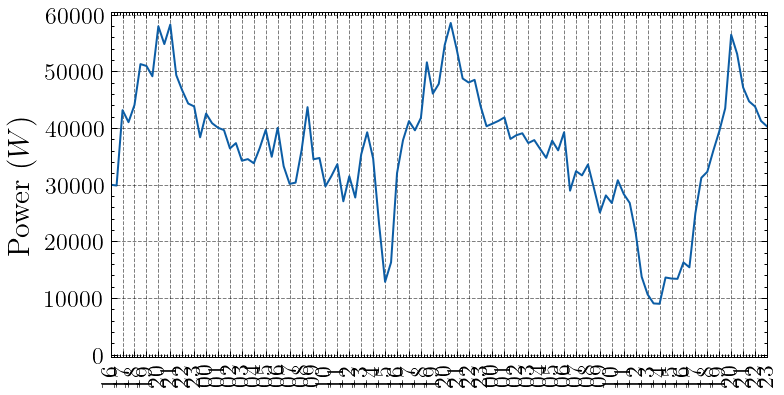

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5.8,3.1), sharey=True, sharex=True)
power=net.loc['2021-08-20 16:00:00': '2021-08-22 23:00:00']
ax.plot(power.index, power['measure_grid'].values)
ax.set_ylabel('Power $(W)$')
ax.autoscale(tight=True)
locator = mdates.HourLocator()
ax.xaxis.set_major_locator(locator)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
t=power['measure_grid'].values
min_y=min(t.min(), 0)-500
max_y=max(t.max(), 60000)+500
ax.set_ylim(min_y, max_y)
    
hfmt = mdates.DateFormatter('%H')
ax.xaxis.set_major_formatter(hfmt)
fig.autofmt_xdate(rotation=90, ha='center')
fig.tight_layout()
fig.savefig(f"real_time_{encoder}_bad_day_net_load.pdf", dpi=480)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,3.1), sharey=True, sharex=True)
ghi=rad.loc['2021-08-20 16:00:00': '2021-08-21 23:00:00']
ax.plot(ghi.index, ghi['ghi'].values)
ax.set_ylabel('Power $(W)$')
ax.autoscale(tight=True)
locator = mdates.HourLocator()
ax.xaxis.set_major_locator(locator)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
hfmt = mdates.DateFormatter('%H')
ax.xaxis.set_major_formatter(hfmt)
fig.autofmt_xdate(rotation=90, ha='center')
fig.tight_layout()
fig.savefig(f"real_time_{encoder}_bad_day_ghi.pdf", dpi=480)

In [50]:
def plot_prediction_with_pi(ax, true, mu, q_pred, date, true_max=None):
  

    h1 = ax.plot(date, true, ".-", c="#ff7f0e")
    h2 = ax.plot(date, mu,   '--',  c="#1f77b4", alpha=0.8)
    ax.set_ylabel('Power $(W)$')
    N = q_pred.shape[0]
    alpha = np.linspace(0.1, 0.9, N//2).tolist() + np.linspace(0.9, 0.2, 1+N//2).tolist()
    
    for i in range(N):
        y1 = q_pred[i, :]
        y2 = q_pred[-1-i, :]
        h3 = ax.fill_between(date, y1.flatten(), y2.flatten(), color="lightsteelblue", alpha=alpha[1])

    #ax.plot(date, q_pred[-1,:], 'k--')
    #ax.plot(date, q_pred[0,:], 'k--')
    ax.autoscale(tight=True)
    if true_max is None:
        true_max = true.max()+1000
        
    ax.set_ylim(true.min(), true_max)
    
    locator = mdates.HourLocator()
    ax.xaxis.set_major_locator(locator)
    
    hfmt = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(hfmt)
    
    lines =[h1[0], h2[0], h3]
    label = ["True", "Pred median", "$95\%$ Interval"]
    ax.legend(lines, label, loc=0)
    
    return ax

## Bad days 

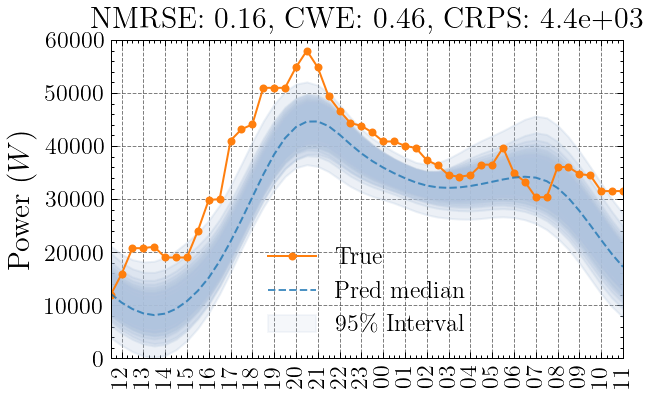

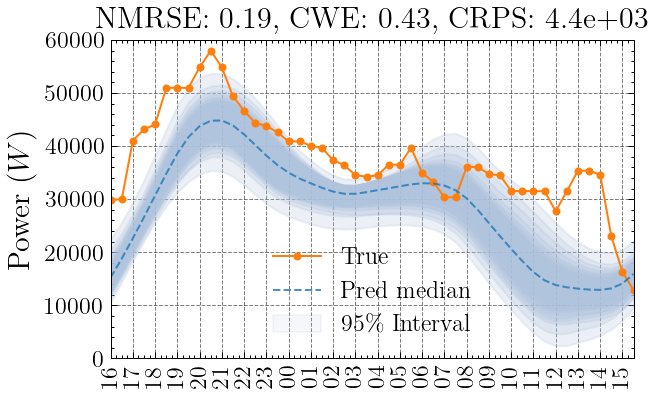

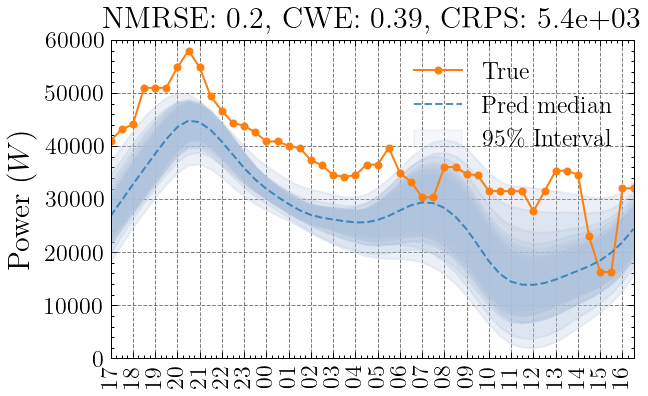

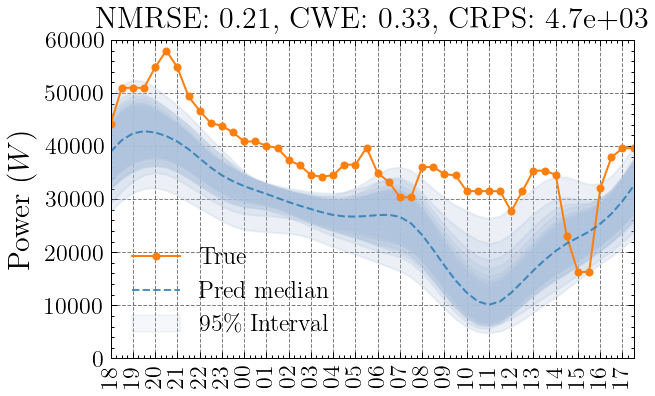

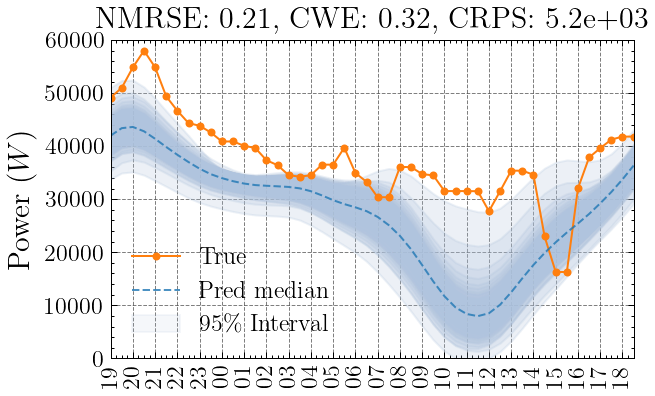

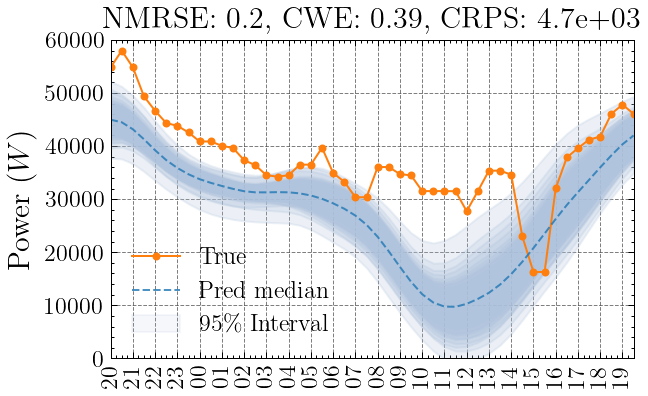

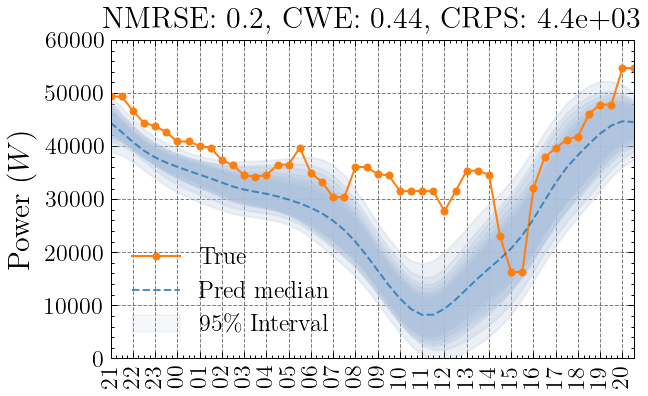

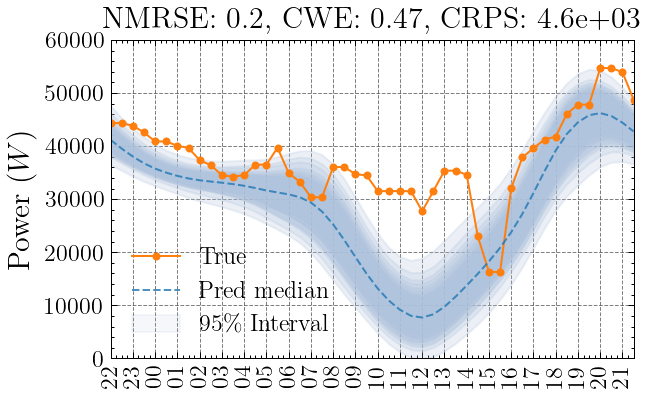

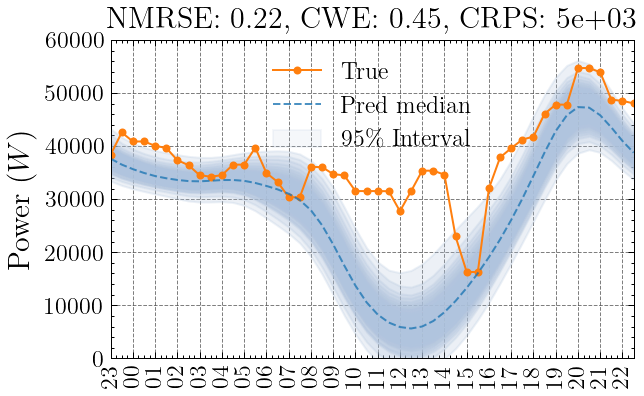

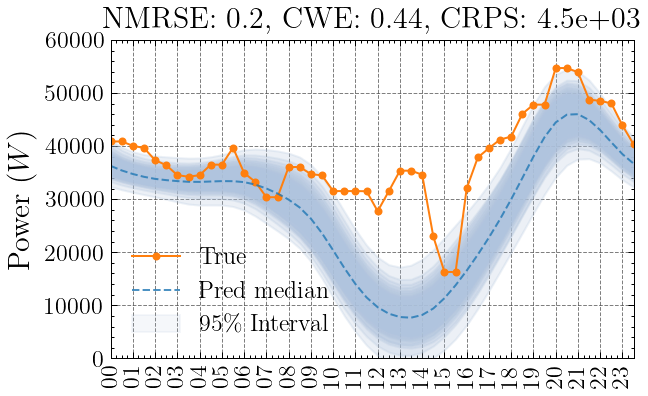

In [51]:
for id, _ in enumerate(bad_day):
    fig, ax = plt.subplots(1, 1, figsize=(4.8,3.1), sharey=True, sharex=True)
    ax=plot_prediction_with_pi(ax, mlp_true[bad_day[id]]['Load-median-filter'].values, 
                                   mlp_preds[bad_day[id]], 
                                   mlp_q_preds[bad_day[id]], 
                                   mlp_true[bad_day[id]].index)

    met=mlp_pd_metrics[bad_day[id]][['nrmse', 'ciwe', 'qncrps']].values[0]
    ax.set_title("NMRSE: {:.2g}, CWE: {:.2g}, CRPS: {:.2g}%".format(met[0], met[1], met[2]), fontsize=15); 
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    t=mlp_true[bad_day[id]]['Load-median-filter'].values
    min_y=min(t.min(), 0)
    max_y=max(t.max(), 60000)
    ax.set_ylim(min_y, max_y)
    fig.autofmt_xdate(rotation=90, ha='center')
    fig.tight_layout()
    fig.savefig(f"real_time_{encoder}_bad_day_forecasted_{id}.pdf", dpi=480)

## Best day 

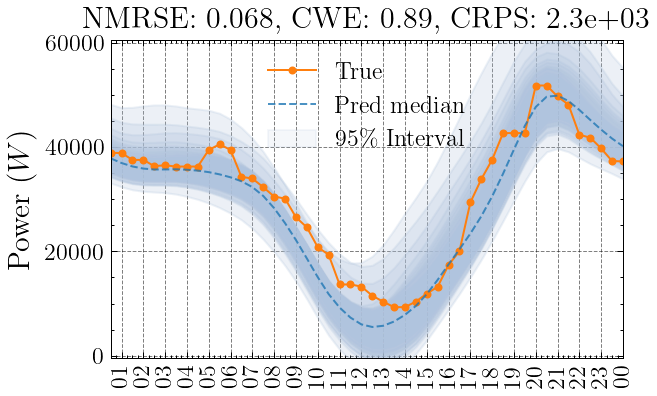

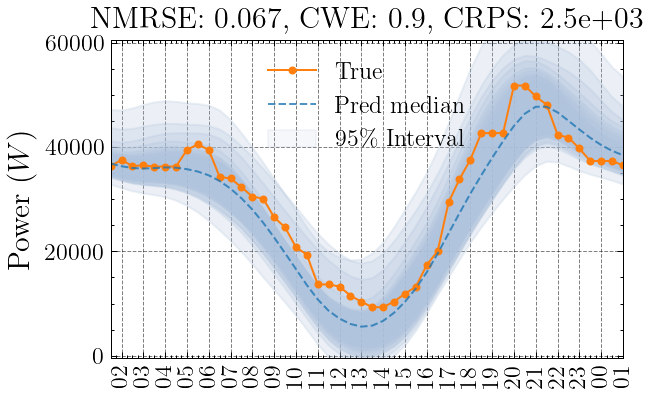

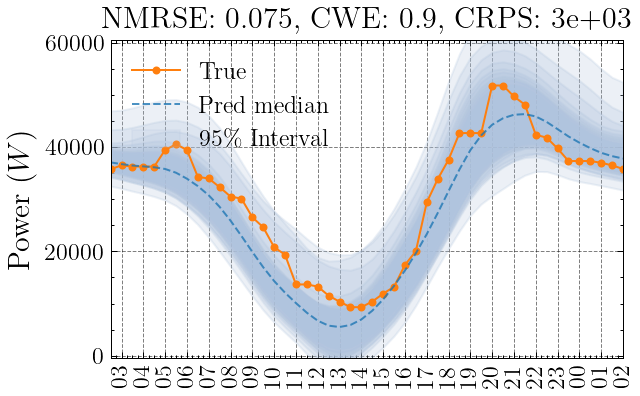

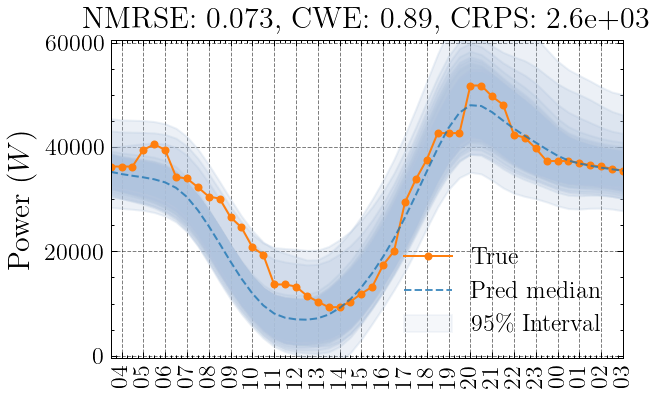

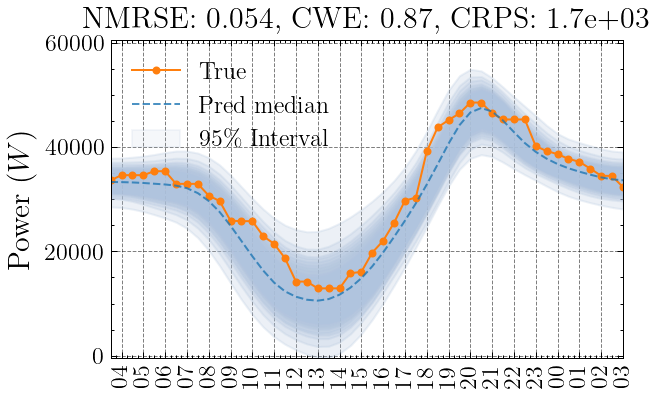

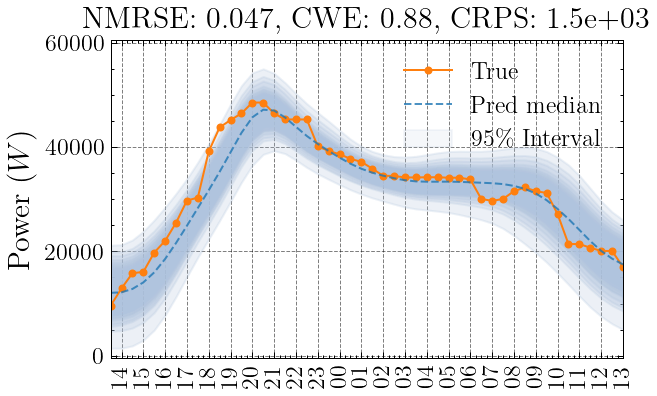

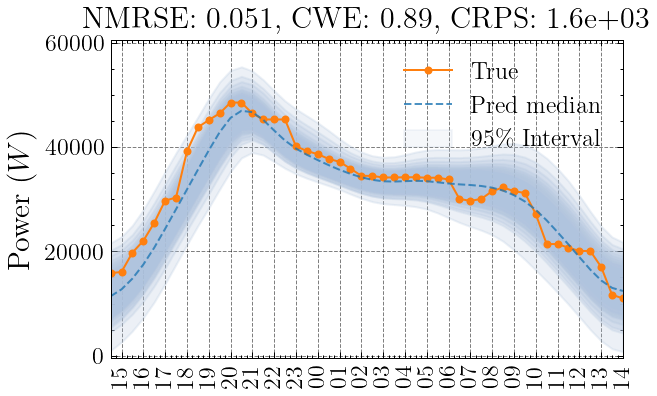

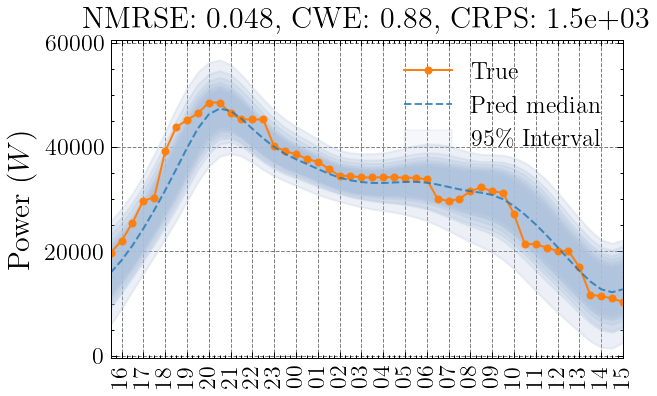

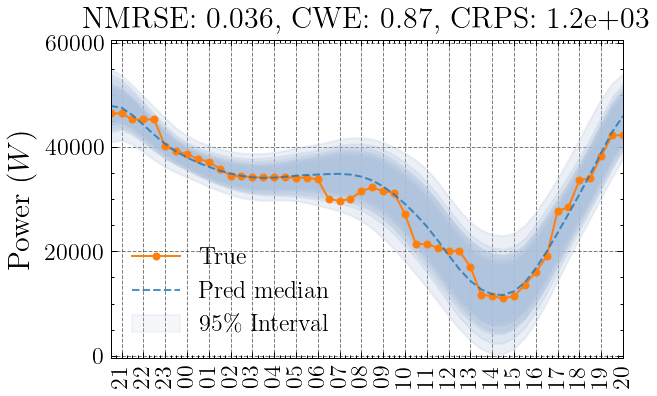

In [52]:

for id, _ in enumerate(best_day):
    fig, ax = plt.subplots(1, 1, figsize=(4.8,3.1), sharey=True, sharex=True)
    ax=plot_prediction_with_pi(ax, mlp_true[best_day[id]]['Load-median-filter'].values, 
                                   mlp_preds[best_day[id]], 
                                   mlp_q_preds[best_day[id]], 
                                   mlp_true[best_day[id]].index)

    met=mlp_pd_metrics[best_day[id]][['nrmse', 'ciwe', 'qncrps']].values[0]
    ax.set_title("NMRSE: {:.2g}, CWE: {:.2g}, CRPS: {:.2g}%".format(met[0], met[1], met[2]), fontsize=15); 
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    t=mlp_true[bad_day[id]]['Load-median-filter'].values
    min_y=min(t.min(), 0)-500
    max_y=max(t.max(), 60000)+500
    ax.set_ylim(min_y, max_y)
    fig.autofmt_xdate(rotation=90, ha='center')
    fig.tight_layout()
    fig.savefig(f"real_time_{encoder}_best_day_forecast_{id}.pdf", dpi=480)
    
    

In [53]:

mlp_pd_metrics_f=pd.concat(list(mlp_pd_metrics.values()))
print_metrics(mlp_pd_metrics_f.iloc[best.tolist()])

2.62 $\pm$ 0.74 &                 0.06 $\pm$ 0.01 &                 1.99 $\pm$ 0.63 &                  1.00 $\pm$ 0.00 &                 0.34 $\pm$ 0.07&                 0.88 $\pm$ 0.01&                  0.97 $\pm$ 0.01 \


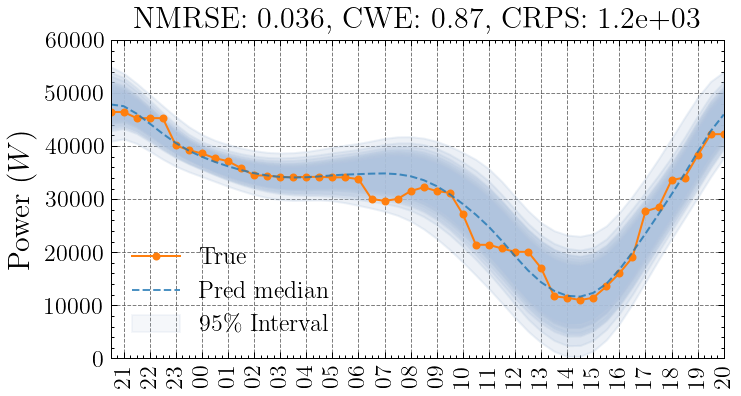

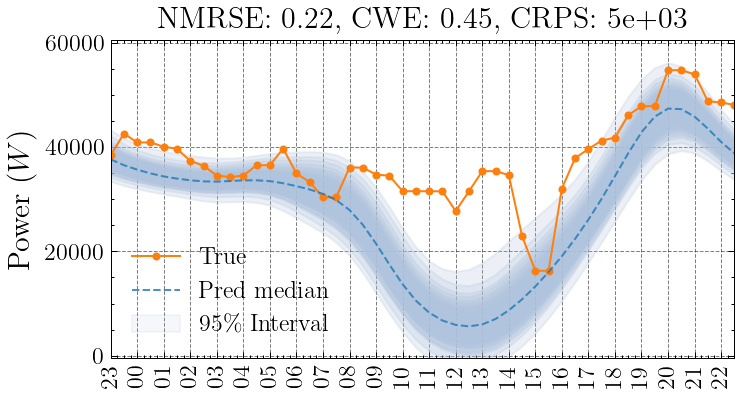

In [54]:
plot_bad_good_forecast(mlp_true,
                       mlp_preds, 
                       mlp_q_preds ,
                           mlp_pd_metrics_f, 
                           good_forecast, 
                           bad_forecast,
                          encoder='MLP_FORECASTED')
                                                

## MLP historical

In [59]:
use_forested_radition=False
encoder="MLPEncoder"
mlp_pd_metrics_h, mlp_features_h, mlp_preds_h, mlp_q_preds_h, mlp_true_h, mlp_tau_hat_h=run_real_time_result(future_rad, 
                         net_load, 
                         rad, 
                         encoder, 
                         experiment, 
                         use_forested_radition, ensemble)




3.70 $\pm$ 1.08 &                 0.08 $\pm$ 0.02 &                 2.59 $\pm$ 0.76 &                  0.92 $\pm$ 0.09 &                 0.31 $\pm$ 0.04&                 0.76 $\pm$ 0.08&                  0.94 $\pm$ 0.04 \


In [56]:
mlp_pd_metrics_h=pd.concat(list(mlp_pd_metrics_h.values()))
print_metrics(mlp_pd_metrics_h.iloc[best.tolist()])

2.88 $\pm$ 0.63 &                 0.06 $\pm$ 0.01 &                 2.14 $\pm$ 0.54 &                  1.00 $\pm$ 0.01 &                 0.34 $\pm$ 0.07&                 0.88 $\pm$ 0.02&                  0.96 $\pm$ 0.01 \


In [57]:

print_metrics(mlp_pd_metrics_h.iloc[best.tolist()])

2.88 $\pm$ 0.63 &                 0.06 $\pm$ 0.01 &                 2.14 $\pm$ 0.54 &                  1.00 $\pm$ 0.01 &                 0.34 $\pm$ 0.07&                 0.88 $\pm$ 0.02&                  0.96 $\pm$ 0.01 \


## Bad days with CWE less than 50 

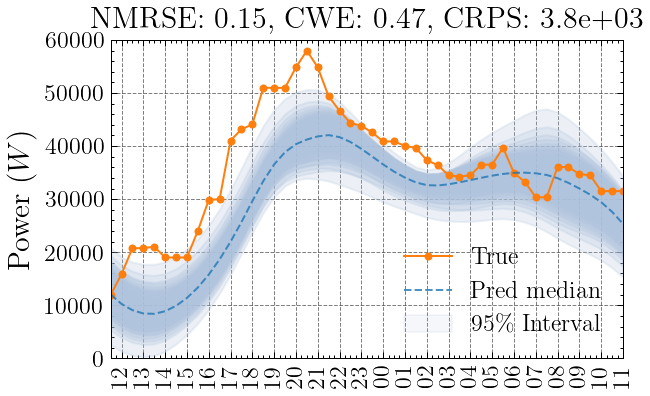

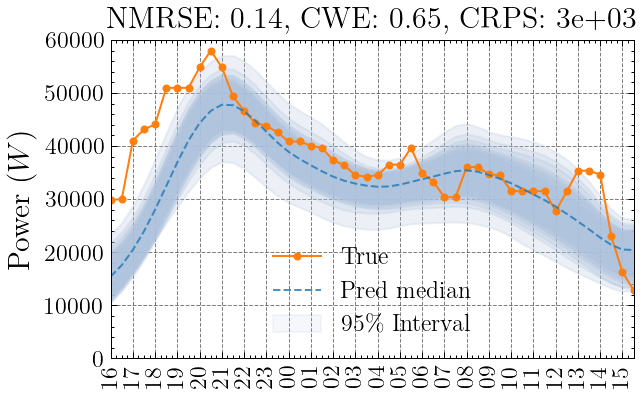

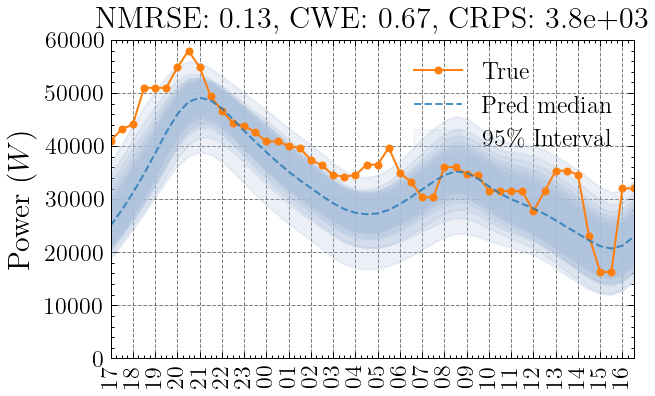

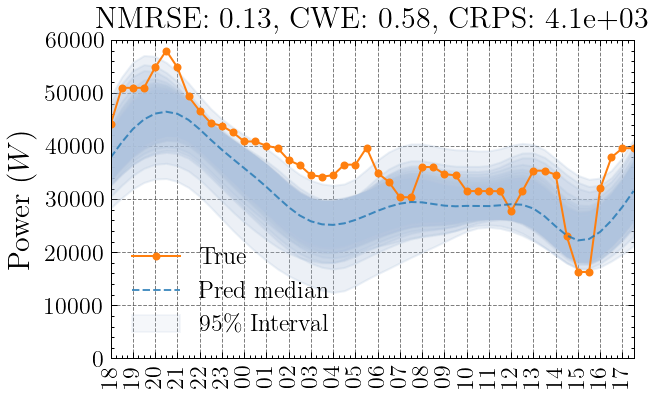

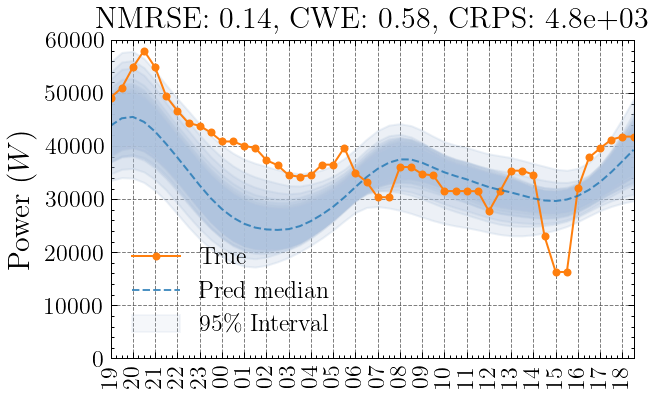

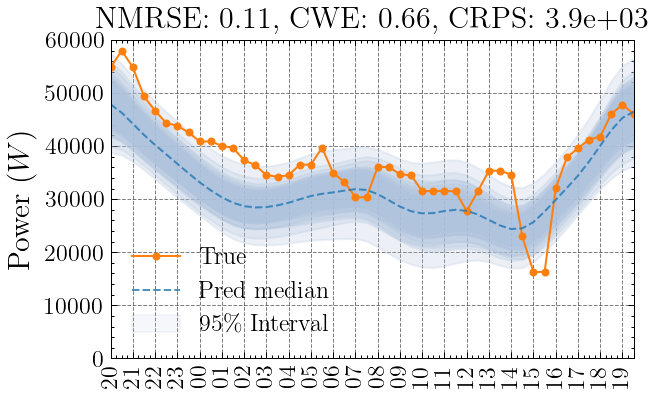

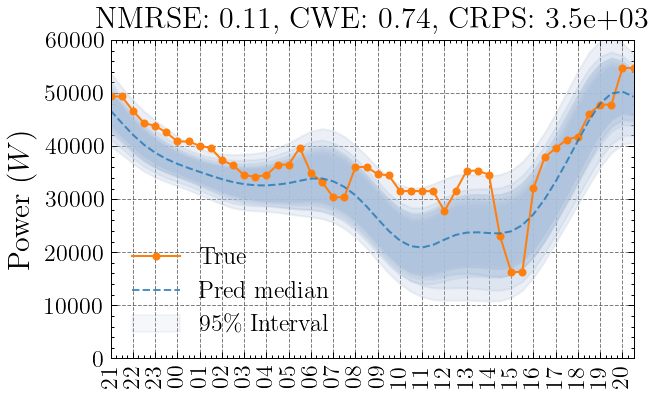

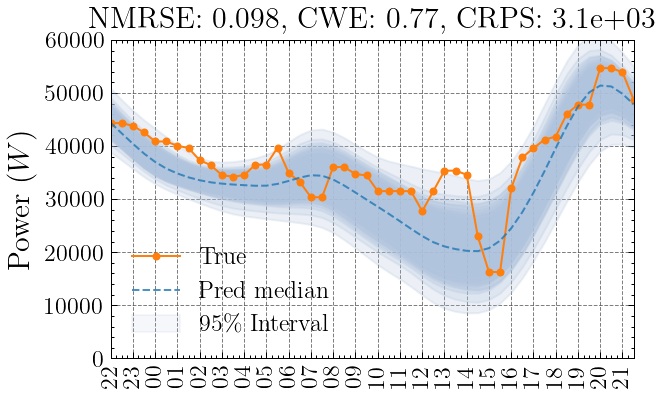

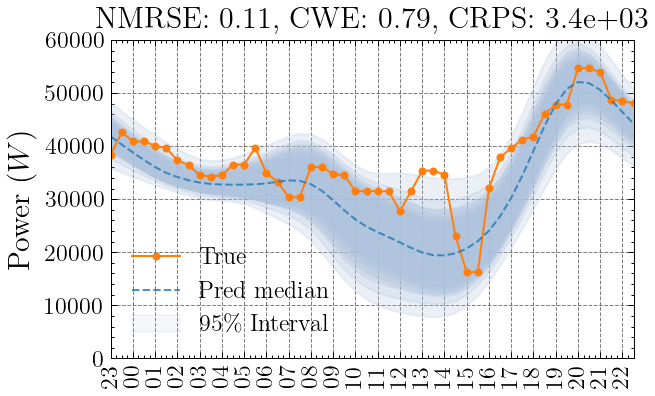

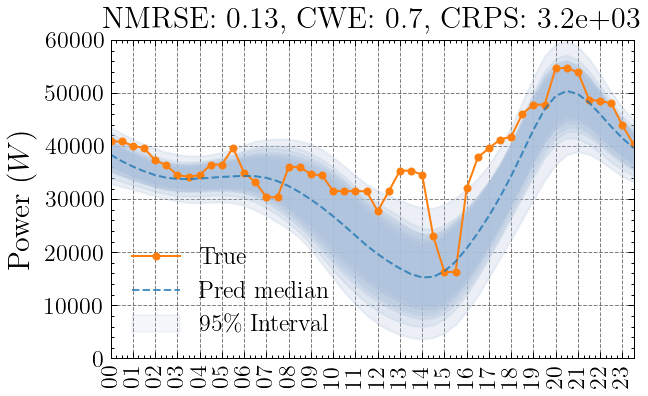

In [60]:

for id, _ in enumerate(bad_day):
    fig, ax = plt.subplots(1, 1, figsize=(4.8,3.1), sharey=True, sharex=True)
    ax=plot_prediction_with_pi(ax, mlp_true_h[bad_day[id]]['Load-median-filter'].values, 
                                   mlp_preds_h[bad_day[id]], 
                                   mlp_q_preds_h[bad_day[id]], 
                                   mlp_true_h[bad_day[id]].index)

    met=mlp_pd_metrics_h[bad_day[id]][['nrmse', 'ciwe', 'qncrps']].values[0]
    ax.set_title("NMRSE: {:.2g}, CWE: {:.2g}, CRPS: {:.2g}%".format(met[0], met[1], met[2]), fontsize=15); 
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    t=mlp_true[bad_day[id]]['Load-median-filter'].values
    min_y=min(t.min(), 0)
    max_y=max(t.max(), 60000)
    ax.set_ylim(min_y, max_y)
    fig.autofmt_xdate(rotation=90, ha='center')
    fig.tight_layout()
    fig.savefig(f"real_time_{encoder}_bad_day_historical_{id}.pdf", dpi=480)

## Bad days with CWE less than 0.5

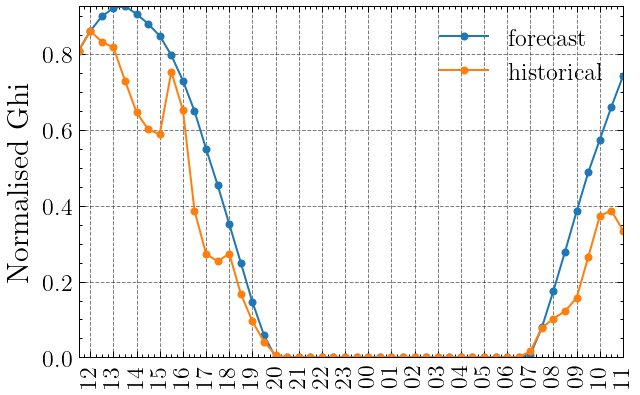

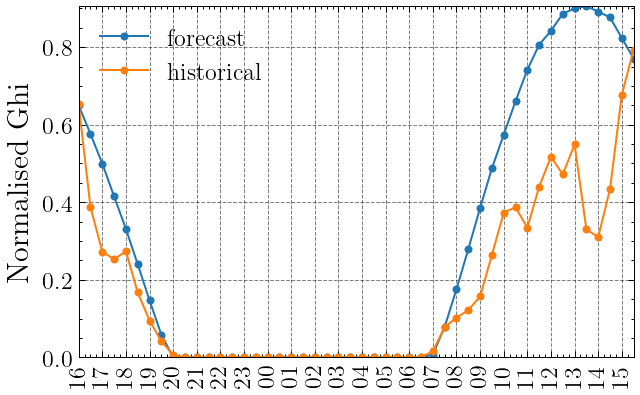

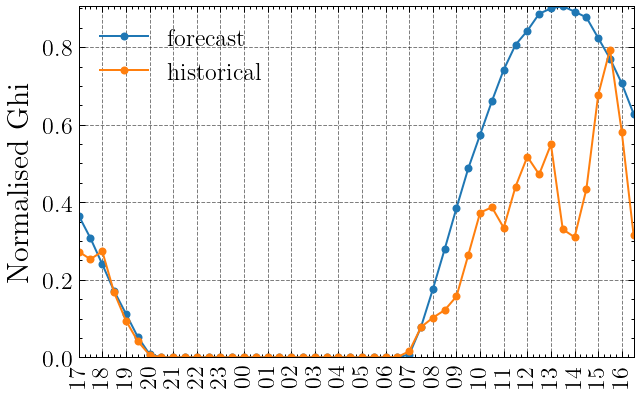

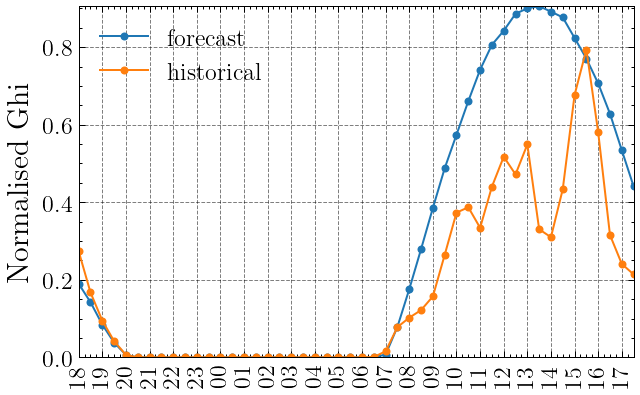

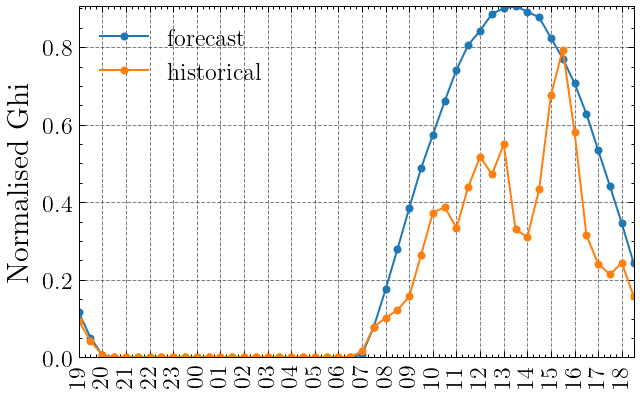

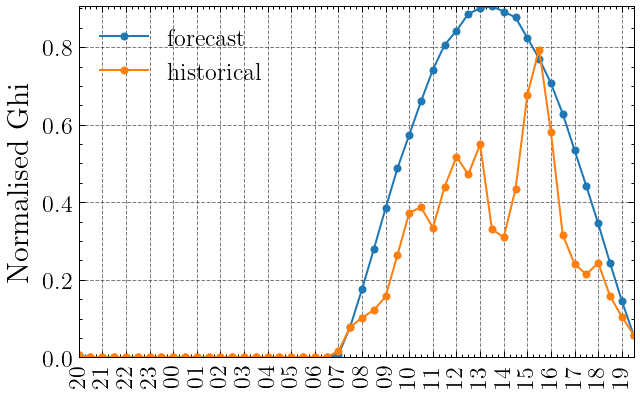

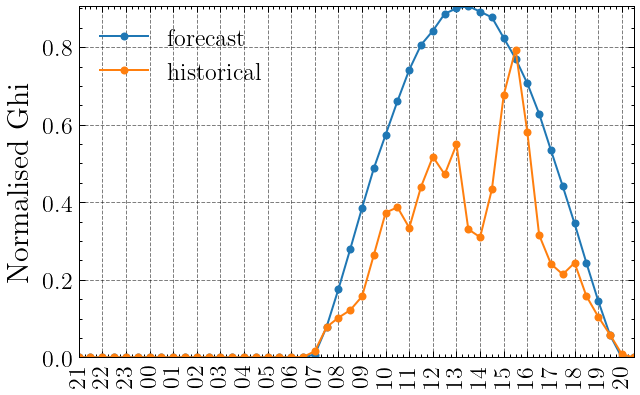

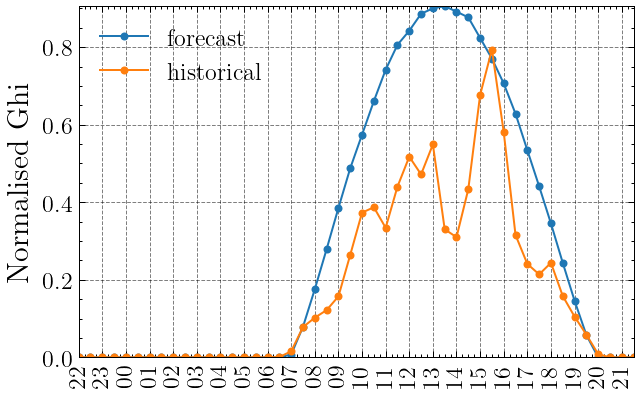

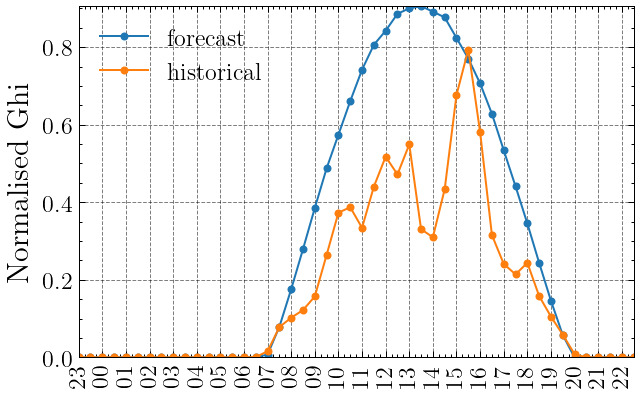

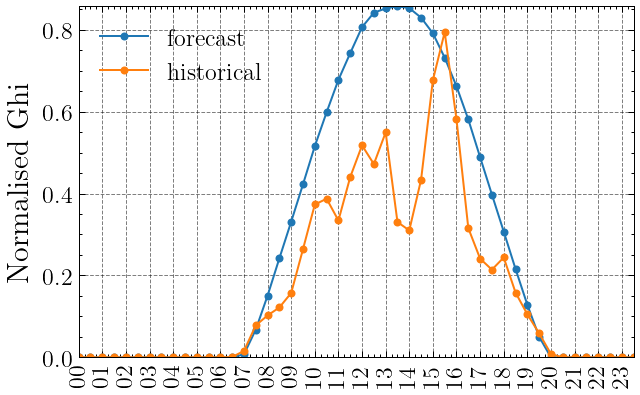

In [66]:
for id, _ in enumerate(bad_day):
    fig, ax = plt.subplots(1, 1, figsize=(4.8,3.1), sharey=True, sharex=True)
    ax.plot(mlp_true_h[bad_day[id]].index, mlp_features[bad_day[id]][0][96:, 1], '.-',  c="#1f77b4", label="forecast")
    ax.plot(mlp_true_h[bad_day[id]].index, mlp_features_h[bad_day[id]][0][96:, 1], ".-", c="#ff7f0e", label="historical")
    ax.set_ylabel('Normalised Ghi')
    ax.autoscale(tight=True)
    locator = mdates.HourLocator()
    ax.xaxis.set_major_locator(locator)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    hfmt = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(hfmt)
    fig.autofmt_xdate(rotation=90, ha='center')
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"real_time_{encoder}_bad_day_ghi_{id}.pdf", dpi=480)
    



## Good days with CWE above 0.87

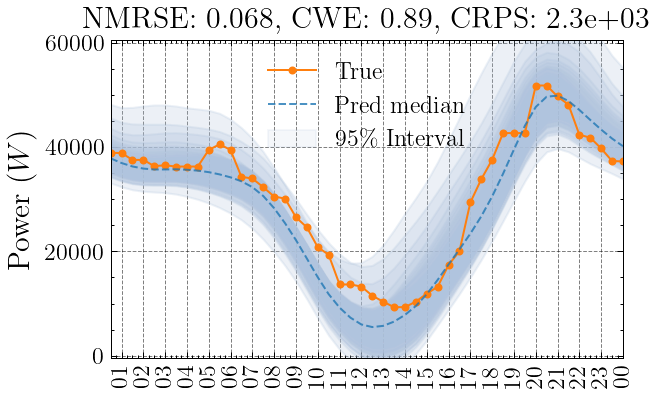

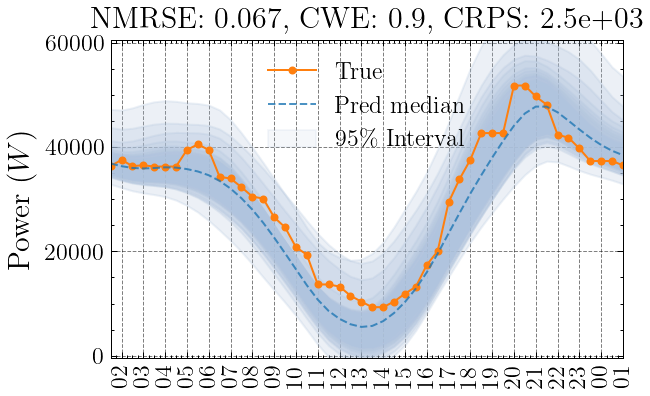

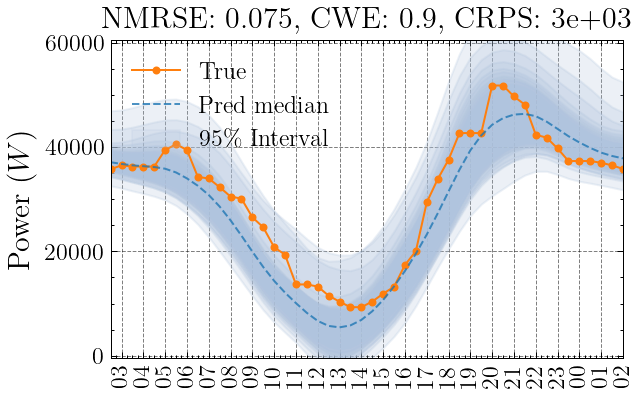

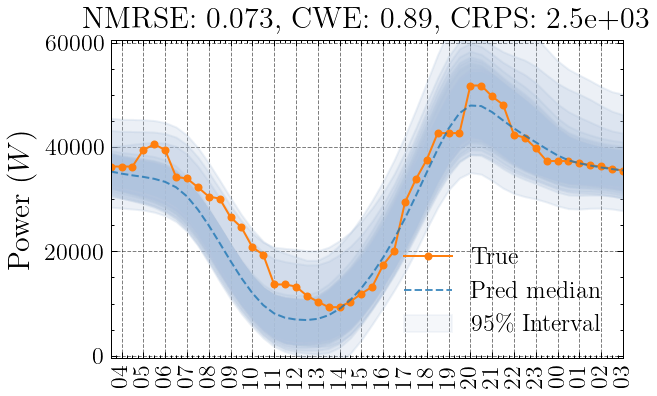

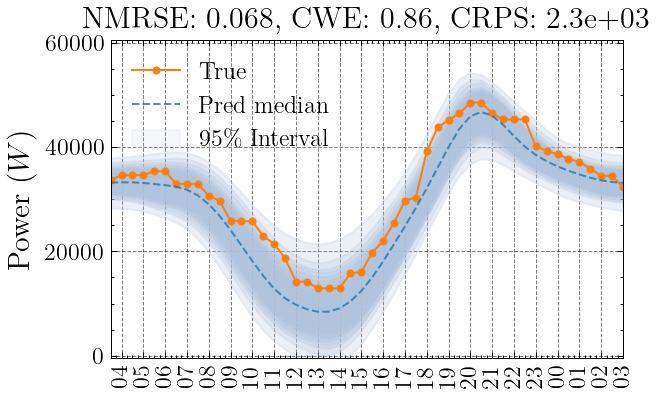

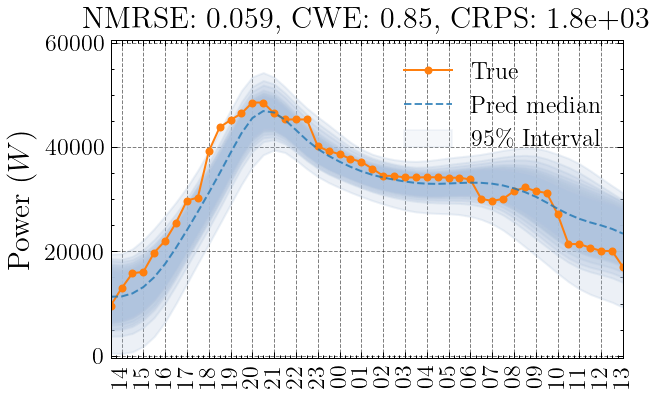

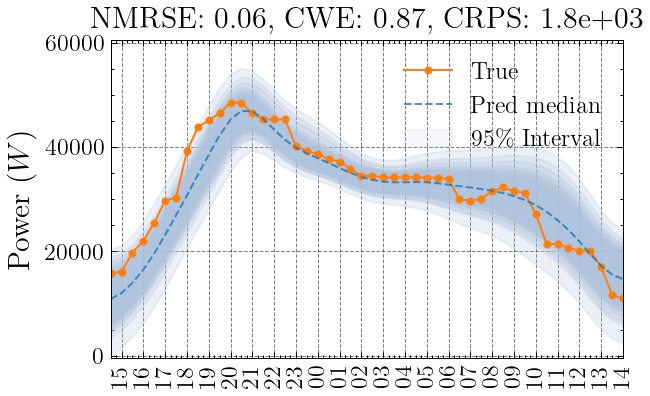

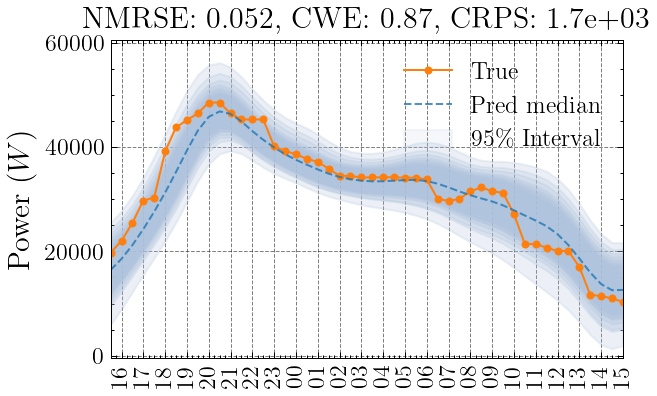

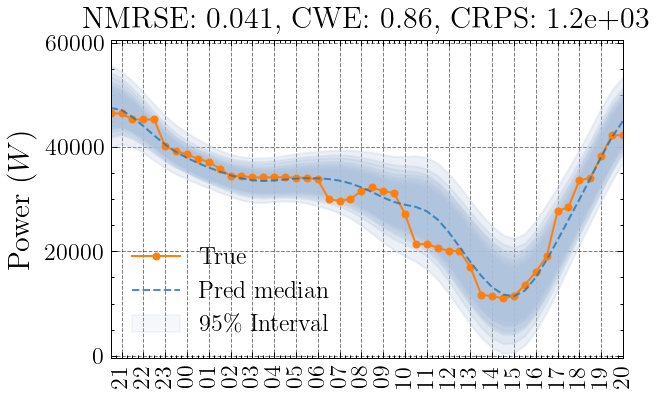

In [62]:

for id, _ in enumerate(best_day):
    fig, ax = plt.subplots(1, 1, figsize=(4.8,3.1), sharey=True, sharex=True)
    ax=plot_prediction_with_pi(ax, mlp_true_h[best_day[id]]['Load-median-filter'].values, 
                                   mlp_preds_h[best_day[id]], 
                                   mlp_q_preds_h[best_day[id]], 
                                   mlp_true_h[best_day[id]].index)

    met=mlp_pd_metrics_h[best_day[id]][['nrmse', 'ciwe', 'qncrps']].values[0]
    ax.set_title("NMRSE: {:.2g}, CWE: {:.2g}, CRPS: {:.2g}%".format(met[0], met[1], met[2]), fontsize=15); 
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    t=mlp_true[bad_day[id]]['Load-median-filter'].values
    min_y=min(t.min(), 0)-500
    max_y=max(t.max(), 60000)+500
    ax.set_ylim(min_y, max_y)
    fig.autofmt_xdate(rotation=90, ha='center')
    fig.tight_layout()
    fig.savefig(f"real_time_{encoder}_best_day_historical_{id}.pdf", dpi=480)
    
    

In [ ]:
for id, _ in enumerate(best_day):
    fig, ax = plt.subplots(1, 1, figsize=(4.8,3.1), sharey=True, sharex=True)
    ax.plot(mlp_true_h[best_day[id]].index, mlp_features[best_day[id]][0][96:, 1], '.-',  c="#1f77b4", label="forecast")
    ax.plot(mlp_true_h[best_day[id]].index, mlp_features_h[best_day[id]][0][96:, 1], ".-", c="#ff7f0e", label="historical")
    ax.set_ylabel('Normalised Ghi')
    ax.autoscale(tight=True)
    locator = mdates.HourLocator()
    ax.xaxis.set_major_locator(locator)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    hfmt = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(hfmt)
    fig.autofmt_xdate(rotation=90, ha='center')
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"real_time_{encoder}_best_day_ghi_{id}.pdf", dpi=480)
   

In [64]:
mlp_pd_metrics_h=pd.concat(list(mlp_pd_metrics_h.values()))
print_metrics(mlp_pd_metrics_h.iloc[best.tolist()])

2.88 $\pm$ 0.63 &                 0.06 $\pm$ 0.01 &                 2.14 $\pm$ 0.54 &                  1.00 $\pm$ 0.01 &                 0.34 $\pm$ 0.07&                 0.88 $\pm$ 0.02&                  0.96 $\pm$ 0.01 \


In [ ]:
bad_forecast=np.where(mlp_pd_metrics_h['ciwe'].values==mlp_pd_metrics_h['ciwe'].min())[0][0]
good_forecast=np.where(mlp_pd_metrics_h['ciwe'].values==mlp_pd_metrics_h['ciwe'].max())[0][0]

In [ ]:
plot_bad_good_forecast(mlp_true,
                       mlp_preds_h, 
                       mlp_q_preds_h ,
                           mlp_pd_metrics_h, 
                           good_forecast, 
                           bad_forecast,
                          encoder='MLP_HISTORICAL')
                                                

In [ ]:
plt.plot(mlp_true_h[best_day[10]]['Load-median-filter'].values)
plt.plot(mlp_preds_h[best_day[10]])
plt.plot(mlp_q_preds_h[best_day[10]][0], 'k--')
plt.plot(mlp_q_preds_h[best_day[10]][-1], 'k--')

In [ ]:
def skill(model, baseline):
    return round(1- (model/baseline), 2)

In [ ]:
skill(2.230, 4.09)

In [ ]:
best=np.where(mlp_pd_metrics_f['mae']<=4)[0]
bad=np.where(mlp_pd_metrics_f['mae'].values>4)[0]
keys = list(mlp_features.keys())
best_day = [keys[i] for i in best.tolist()]
bad_day = [keys[i] for i in bad.tolist()]

In [ ]:
len(best_day)

In [ ]:
np.median(mlp_pd_metrics_f['mae'])

In [ ]:
plt.plot(mlp_true_h[best_day[10]]['Load-median-filter'].values)
plt.plot(mlp_preds_h[best_day[10]])
plt.plot(mlp_q_preds_h[best_day[10]][0], 'k--')
plt.plot(mlp_q_preds_h[best_day[10]][-1], 'k--')